<a href="https://colab.research.google.com/github/Molten-Ice/Deep-Learning/blob/colab/CycleGAN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install ipywidgets --user
# !pip install kaggle
# !pip3 install ipywidgets --user
# !pip3 install kaggle
# !pip3 install torch
# !pip3 install matplotlib

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"number of gpus: {torch.cuda.device_count()}")
# device = "cpu"
print(device)

batch_size = 1

cpu


In [ ]:
 #Connecting to kaggle API
import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

# base_dir = '/home/azureuser/'
base_dir = "/home/fsuser/"
kaggle_dir = base_dir + '.kaggle'
print("base_dir:", base_dir)
print("kaggle_dir:", kaggle_dir)
if not os.path.exists(kaggle_dir): os.mkdir(kaggle_dir)

with open(kaggle_dir+'/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

# open file at ~/.kaggle/kaggle.json and print it
with open(kaggle_dir+'/kaggle.json', 'r') as f:
    print(f.read())

base_path = "/home/fsuser/Deep-Learning/"
data_path = base_path+"downloaded-data/"
if not os.path.exists(data_path): os.mkdir(data_path)
!kaggle config set -n path -v {data_path}

In [ ]:
# Download simpsons dataset from kaggle
! kaggle datasets download -d kostastokis/simpsons-faces

#unzip file simpsons-faces.zip
with zipfile.ZipFile(data_path+"datasets/kostastokis/simpsons-faces/simpsons-faces.zip","r") as zip_ref:
    zip_ref.extractall(data_path)

# Download faces dataset from kaggle
! kaggle datasets download -d atulanandjha/lfwpeople

with zipfile.ZipFile(data_path+"datasets/atulanandjha/lfwpeople/lfwpeople.zip","r") as zip_ref:
    zip_ref.extractall(data_path)

import tarfile
tar = tarfile.open(data_path+"lfw-funneled.tgz")
tar.extractall(data_path)
tar.close()

In [ ]:
names = sorted(os.listdir(data_path+'lfw_funneled'))[:-12]
print("number of people:", len(names), names[:5])

faces_file_paths = []
counter= 0 
for name in names:
    images_in_folder = os.listdir(data_path+'lfw_funneled/'+name)
    faces_file_paths.extend([name+"/"+x for x in images_in_folder[:2]])
    counter += 1
    if counter > 10000: break # Deleted this line to get all the images

print("number of face images:", len(faces_file_paths), faces_file_paths[:5])

simpson_file_paths = sorted(os.listdir(data_path+'cropped'))
print("number of simpsons images:", len(simpson_file_paths), simpson_file_paths[:5])

In [53]:
#  #Connecting to kaggle API
# import json
# import zipfile
# kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

# base_dir = '/home/azureuser/'
# kaggle_dir = base_dir + '.kaggle'
# print("base_dir:", base_dir[0])
# print("kaggle_dir:", kaggle_dir)
# if not os.path.exists(kaggle_dir): os.mkdir(kaggle_dir)

# with open(kaggle_dir+'/kaggle.json', 'w') as f:
#     json.dump(kaggle_apikey, f)

# ! chmod 600 ~/.kaggle/kaggle.json

# # open file at ~/.kaggle/kaggle.json and print it
# with open(kaggle_dir+'/kaggle.json', 'r') as f:
#     print(f.read())

# # Download simpsons dataset from kaggle
# ! kaggle datasets download -d kostastokis/simpsons-faces
# #unzip file simpsons-faces.zip
# with zipfile.ZipFile("simpsons-faces.zip","r") as zip_ref:
#     zip_ref.extractall("simpsons-data")


# # Download faces dataset from kaggle
# ! kaggle datasets download -d atulanandjha/lfwpeople
# with zipfile.ZipFile("lfwpeople.zip","r") as zip_ref:
#     zip_ref.extractall()

# import tarfile
# tar = tarfile.open("lfw-funneled.tgz")
# tar.extractall()
# tar.close()

# names = sorted(os.listdir('lfw_funneled'))[:-12]
# print("number of people:", len(names), names[:5])

# faces_file_paths = []
# counter= 0 
# for name in names:
#     images_in_folder = os.listdir('lfw_funneled/'+name)
#     faces_file_paths.extend([name+"/"+x for x in images_in_folder[:2]])
#     counter += 1
#     if counter > 10000: break # Deleted this line to get all the images

# print("number of face images:", len(faces_file_paths), faces_file_paths[:5])

# simpson_file_paths = sorted(os.listdir('simpsons-data/cropped'))
# print("number of simpsons images:", len(simpson_file_paths), simpson_file_paths[:5])

base_dir: /
kaggle_dir: /home/azureuser/.kaggle
{"username": "jamesdavey", "key": "a8975caa44cfa08d6f2164f2d5977b6e"}


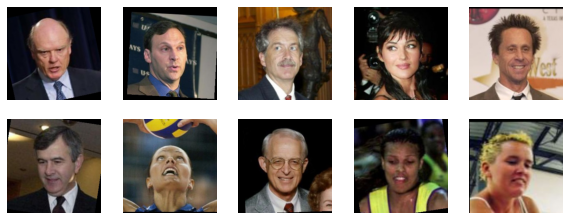

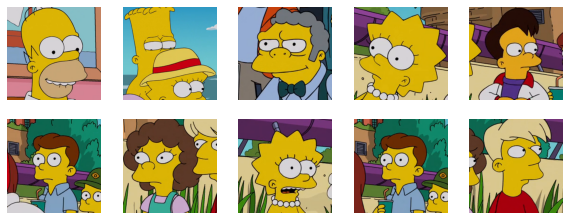

In [56]:
# display 10 faces images
random_indices = np.random.randint(0, len(faces_file_paths), 10)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread('lfw_funneled/'+faces_file_paths[random_indices[i]])
    plt.imshow(img)
    plt.axis('off')
plt.show()

# display 10 simpsons images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread('simpsons-data/cropped/'+simpson_file_paths[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [57]:
#Create traindataloader from simpsons dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, file_paths, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = file_paths
        self.len = len(self.file_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img = plt.imread(self.root_dir + self.file_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img

# faces_mean = 0.0
# faces_std = 0.0
# for img in faces_dataset:
#     faces_mean+=img.mean([1,2])
#     faces_std+=img.std([1,2])
# faces_mean = faces_mean/len(faces_dataset)
# faces_std = faces_std/len(faces_dataset)
# print(faces_mean, faces_std)

# simpsons_mean = 0.0
# simpsons_std = 0.0
# for img in simpsons_dataset:
#     simpsons_mean+=img.mean([1,2])
#     simpsons_std+=img.std([1,2])
    
# simpsons_mean = simpsons_mean/len(simpsons_dataset)
# simpsons_std = simpsons_std/len(simpsons_dataset)
# print(simpsons_mean, simpsons_std)
    
faces_mean, faces_std = (0.4339, 0.3770, 0.3373), (0.2682, 0.2454, 0.2354)
simp_mean, simp_std = (0.6018, 0.5183, 0.2937), (0.2526, 0.2123, 0.2660)

faces_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)),
                                       transforms.Normalize(faces_mean, faces_std)])
simp_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((256,256)),
                                       transforms.Normalize(simp_mean, simp_std)])

#Modify these paths
print("total simpsons images:", len(simpson_file_paths), "| total faces images:", len(faces_file_paths))
max_length = min(len(simpson_file_paths), len(faces_file_paths))
faces_dataset = CustomDataset('lfw_funneled/', faces_file_paths[:max_length], transform=faces_transforms)
simpsons_dataset = CustomDataset('simpsons-data/cropped/', simpson_file_paths[:max_length], transform=simp_transforms)

# create dataloaders
faces_dataloader = torch.utils.data.DataLoader(faces_dataset, batch_size=batch_size, shuffle=True)
simpsons_dataloader = torch.utils.data.DataLoader(simpsons_dataset, batch_size=batch_size, shuffle=True)
print("simpsons_dataloader:", len(simpsons_dataloader), "of batch size", batch_size)
print("faces_dataloader:", len(faces_dataloader), "of batch size", batch_size)


total simpsons images: 9877 | total faces images: 7428
simpsons_dataloader: 7428 of batch size 1
faces_dataloader: 7428 of batch size 1


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


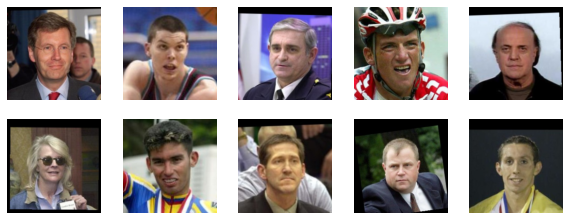

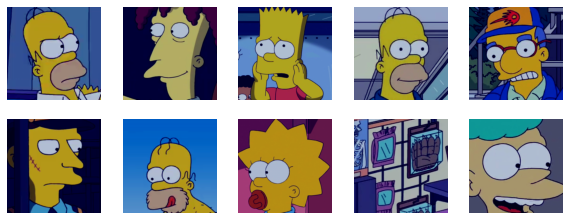

In [58]:
inv_transformation_face = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = ([1/s for s in faces_std])),
                                                transforms.Normalize(mean = [ -m for m in faces_mean ],
                                                                    std = [ 1., 1., 1. ])])
inv_transformation_simp = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = ([1/s for s in simp_std])),     
                                                  transforms.Normalize(mean = [ -m for m in simp_mean ],
                                                                        std = [ 1., 1., 1. ])])
                                                                        
# display 10 images
plt.figure(figsize=(10,10))
for i, batch in enumerate(faces_dataloader):
    for j in range(batch_size):
        if i*batch_size+j >=10: break
        plt.subplot(5,5,i*batch_size+j+1)
        image = inv_transformation_face(torch.Tensor(batch[j]))
        plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
        plt.axis('off')
    if i*batch_size+j >=10: break
plt.show()

# display 10 images
plt.figure(figsize=(10,10))
for i, batch in enumerate(simpsons_dataloader):
    for j in range(batch_size):
        if i*batch_size+j >=10: break
        plt.subplot(5,5,i*batch_size+j+1)
        image = inv_transformation_face(torch.Tensor(batch[j]))
        plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
        plt.axis('off')
    if i*batch_size+j >=10: break
plt.show()

In [59]:
##############################################################################
# Models
##############################################################################
### Alternative Generator
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, bias=True, padding_mode='reflect', **kwargs) 
#             if down 
#             else nn.ConvTranspose2d(in_channels, out_channels, bias=True, **kwargs),
#             nn.InstanceNorm2d(out_channels),
#             nn.ReLU(inplace=True) if use_act else nn.Identity())
#     def forward(self, x):
#         return self.conv(x)

# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.block = nn.Sequential(
#             ConvBlock(channels, channels, kernel_size=3, padding=1),
#             ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1))

#     def forward(self, x):
#         return x + self.block(x)

# class Generator(nn.Module):
#     def __init__(self, img_channels, num_features=64, num_residuals=9):
#         super().__init__()
#         self.initial = nn.Sequential(
#             nn.Conv2d(img_channels, 64, 7, 1, 3, bias=True, padding_mode='reflect'),
#             nn.InstanceNorm2d(64),
#             nn.ReLU(inplace=True))

#         self.down_blocks = nn.ModuleList([
#             ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
#             ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1)])
        
#         self.residual_blocks = nn.Sequential(*[ResidualBlock(num_features*4) for _ in range(num_residuals)])

#         self.up_blocks = nn.ModuleList([
#             ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
#             ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)])


#         self.last = nn.Conv2d(num_features, img_channels, 7, 1, 3, bias=True, padding_mode='reflect')

#     def forward(self, x):
#         x = self.initial(x)
#         for down_block in self.down_blocks:
#             x = down_block(x)
#         x = self.residual_blocks(x)
#         for up_block in self.up_blocks:
#             x = up_block(x)
#         return torch.tanh(self.last(x))

class DoubleConv(nn.Module):
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
      
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    conv1 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
    conv2 = nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)

    nn.init.normal_(conv1.weight, mean=0.0, std= (2/(9*input_channels))**(1/2)) #sqrt(2/N)
    nn.init.normal_(conv2.weight, mean=0.0, std= (2/(9*output_channels))**(1/2)) 
    
    self.conv = nn.Sequential(conv1, nn.BatchNorm2d(output_channels), nn.ReLU(),
                              conv2, nn.BatchNorm2d(output_channels), nn.ReLU())
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(x)

class DownSampleBlock(nn.Module):
  """
  DownSampling block in UNET

  MaxPool, DoubleCov
  MaxPool, Conv, BatchNorm, ReLU, Conv, BatchNorm, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.

    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.conv(self.max_pool(x))

class UpSampleBlock(nn.Module):
  """
  UpSampling block in UNET

  Upsample, Conv, Concat, Conv, ReLU, Conv, ReLU
  """
  def __init__(self, input_channels: int, output_channels: int):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      input_size (int) -- input size to block
      input_channels (int) -- #channels into first layer in block
      output_channels (int) -- #channels each layer produces
    """
    super().__init__()
    self.up_sample = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)
    self.conv = DoubleConv(input_channels, output_channels)

  def forward(self, x: torch.Tensor, res: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) -- input tensor to block
      res (torch.Tensor) -- residual connection feeding into block
    
    Return x
    x will be used as the input to the next upsizing block (or final layer)
    """
    x = self.up_sample(x)
    # size_diff1 = (res.shape[2]-x.shape[2])//2
    # size_diff2 = (res.shape[2]-x.shape[2]) - size_diff1
    # x = torch.concat((x, res[:, :, size_diff1:-size_diff2, size_diff1:-size_diff2]), dim = 1)
    x = torch.cat((x, res), dim = 1)
    x = self.conv(x)
    return x

class UNET(nn.Module):
  def __init__(self, channels_in = 3):
    """Initialize the DownSampleBlock class.
    
    Parameters:
      channels_in (int) -- input images channel size
    """
    super().__init__()
    self.first_conv = DoubleConv(channels_in, 64)
    self.downsample_blocks = nn.ModuleList([DownSampleBlock(c, 2*c) for c in [64, 128, 256, 512]])
    self.upsample_blocks = nn.ModuleList([UpSampleBlock(2*c, c) for c in [512, 256, 128, 64]])
    self.final_layer = nn.Conv2d(in_channels=64, out_channels=channels_in, kernel_size=1, stride=1, padding=0)
    self.tanh = nn.Tanh()
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass for DownSampleBlock.

     Parameters:
      x (torch.Tensor) --input tensor to block
      targets (torch.Tensor) --target output of model

    Returns (logits, loss)

    logits (torch.Tensor) --model's raw output
    loss (torch.float32) --2d CrossEntropyLoss result
    """
    x = self.first_conv(x)
    residuals = []
    for downsample in self.downsample_blocks:
      residuals.append(x)
      x = downsample(x)
    for i, upsample in enumerate(self.upsample_blocks):
      x = upsample(x, residuals[-(i+1)])
    x = self.final_layer(x)
    return self.tanh(x)

#### Discriminator ####
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2))
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    """Discriminator network with PatchGAN."""
    def __init__(self, in_channels=3, features = [64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], 4, 2, 1, bias=True, padding_mode='reflect'),
            nn.LeakyReLU(0.2))
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, 1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, 4, 1, 1, bias=True, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

input = torch.randn(5, 3, 256, 256)
D = Discriminator()
print(D(input).shape)

x = torch.randn(5, 3, 256, 256)
G = UNET()
print(G(x).shape)

#number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(G), count_parameters(D)

torch.Size([5, 1, 30, 30])
torch.Size([5, 3, 256, 256])


(31043651, 2764737)

In [60]:
G = UNET().to(device)
F = UNET().to(device)

D_y = Discriminator().to(device)
D_x = Discriminator().to(device)

faces = next(iter(faces_dataloader)).to(device)
simpsons = next(iter(simpsons_dataloader)).to(device)

print(faces.shape, simpsons.shape)
print(G(faces).shape, F(simpsons).shape)
print(D_y(faces).shape, D_y(G(faces)).shape)
print(D_x(simpsons).shape, D_x(F(simpsons)).shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 30, 30]) torch.Size([1, 1, 30, 30])
torch.Size([1, 1, 30, 30]) torch.Size([1, 1, 30, 30])


Generating fake simpsons images (from faces)...


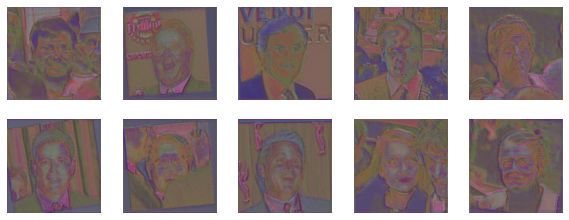

Generating fake faces images (from simpsons)...


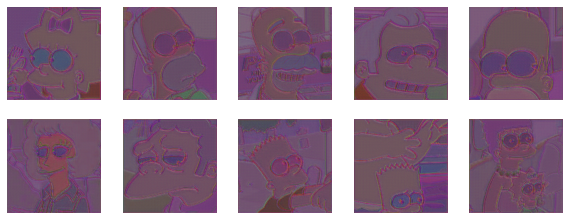

In [61]:
def display_generated_images(G, F):
    print("Generating fake simpsons images (from faces)...")
    # display 10 images
    plt.figure(figsize=(10,10))
    for i, batch in enumerate(faces_dataloader):
        pred_images = G(batch.to(device)).cpu().detach()
        for j in range(batch_size):
            if i*batch_size+j >=10: break 
            plt.subplot(5,5,i*batch_size+j+1)
            image = inv_transformation_face(pred_images[j])
            plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
            plt.axis('off')
        if i*batch_size+j >=10: break 
    plt.show()

    print("Generating fake faces images (from simpsons)...")
    # display 10 images
    plt.figure(figsize=(10,10))
    for i, batch in enumerate(simpsons_dataloader):
        pred_images = F(batch.to(device)).cpu().detach()
        for j in range(batch_size):
            if i*batch_size+j >=10: break 
            plt.subplot(5,5,i*batch_size+j+1)
            image = inv_transformation_face(pred_images[j])
            plt.imshow(image.clip(0,1).permute(1,2,0).numpy())
            plt.axis('off')
        if i*batch_size+j >=10: break 
    plt.show()

display_generated_images(G, F)

0.0002


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


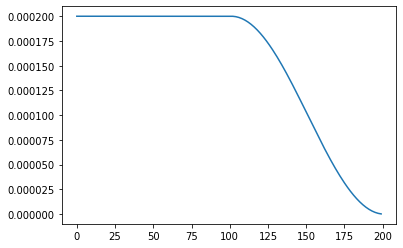

In [62]:
################## Hyperparameters ##################
class Config():
    "Can store this data in a different file instead of class"
    def __init__(self):
        self.lr = 0.0002
        self.betas = (0.5, 0.999)
        self.epochs = 100
        self.batch_size = 16
        self.load_model = False
        self.save_model = False
        self.lambda_cycle = 10

config = Config()
print(config.lr)

optimizer = torch.optim.SGD(nn.Linear(10,10).parameters(), lr=0.0002, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)
lrs = []
for i in range(200):
    lrs.append(scheduler.get_last_lr())
    if i > 100: scheduler.step()

plt.plot(lrs)

In [63]:
################## Training loop ##################
l1_loss_fn = nn.L1Loss()
l2_loss_fn = nn.MSELoss()
G_optimizer = torch.optim.Adam(list(G.parameters()) + list(F.parameters()), lr=config.lr, betas=config.betas)
D_optimizer = torch.optim.Adam(list(D_y.parameters()) + list(D_x.parameters()), lr=config.lr, betas=config.betas)
G_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(G_optimizer, T_max=config.epochs//2, eta_min=0)
D_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(D_optimizer, T_max=config.epochs//2, eta_min=0)

if config.load_model:
    #load checkpoints
    pass

t_interval = time.time()
t_start = time.time()
for epoch in range(config.epochs):
    t_epoch = time.time()
    for batch_idx, (faces, simpsons) in enumerate(zip(faces_dataloader, simpsons_dataloader)):
        B, C, H, W = faces.shape
        faces, simpsons = faces.to(device), simpsons.to(device)

        fake_simpsons = G(faces)
        fake_faces = F(simpsons)
        
        real_labels = torch.ones(B).to(device)
        fake_labels = torch.zeros(B).to(device)

        ########## Train Discriminators ##########
        ## Minimizing D for (D(x) - 1)^2 + (D(G(x)) - 0)^2 ##
        ## D_y - Adversarial loss##
        D_y_real = l2_loss_fn(D_y(simpsons), real_labels)
        D_y_fake = l2_loss_fn(D_y(fake_simpsons.detach()), fake_labels)
        D_y_loss = D_y_real + D_y_fake
        ## D_x - Adversarial loss ##
        D_x_real = l2_loss_fn(D_x(faces), real_labels)
        D_x_fake = l2_loss_fn(D_x(fake_faces.detach()), fake_labels)
        D_x_loss = D_x_real + D_x_fake
        D_loss = (D_y_loss + D_x_loss)/2
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        ########## Train Generators ############
        ## Minimizing G for (D(G(x)) - 1)^2 ##
        ## F - Adversarial loss ##
        D_F_fake = D_x(fake_simpsons)
        D_F_loss = l2_loss_fn(D_F_fake, real_labels)
        ## G - Adversarial loss ##
        D_G_fake = D_y(fake_faces)
        D_G_loss = l2_loss_fn(D_G_fake, real_labels)
        
        ## Cycle consistency loss ##
        cycled_simpsons = G(fake_faces) 
        cycle_consistency_loss_simpsons = l1_loss_fn(cycled_simpsons, simpsons)
        cycled_faces = F(fake_simpsons)
        cycle_consistency_loss_faces = l1_loss_fn(cycled_faces, faces)


        G_loss = D_F_loss + D_G_loss + config.lambda_cycle*cycle_consistency_loss_faces + \
                config.lambda_cycle*cycle_consistency_loss_simpsons

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if config.save_model:
            #save checkpoints at certain epochs
            pass
        #f"Epoch [{epoch}/{config.epochs}] Batch {batch_idx}/{len(faces_dataloader)
        #  Loss D_y: {D_y_loss:.4f}, Loss D_x: {D_x_loss:.4f} loss G: {loss_g:.4f}, loss F: {loss_f:.4f} |)
            
    if epoch > config.epochs//2:
        G_scheduler.step()
        D_scheduler.step()

    print(f"Epoch [{epoch}/{config.epochs}] | lr:{G_scheduler.get_last_lr()} | epoch time {time.time()-t_epoch:.4f}s, total elapsed: {time.time()-t_start:.4f}s")
    display_generated_images(G, F)
    

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

Generating fake simpsons images (from faces)...


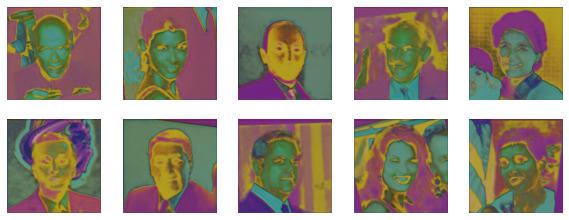

Generating fake faces images (from simpsons)...


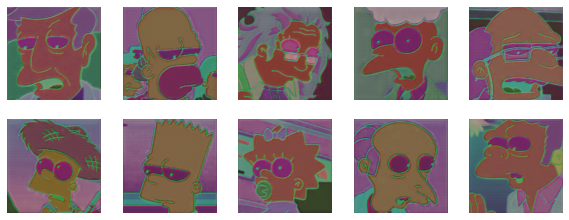

In [65]:
display_generated_images(G, F)

In [ ]:
!mkdir models
torch.save(G.state_dict(), "models/G.pth")
import shutil
shutil.make_archive("G1", 'zip', "models")

In [ ]:
# # upload zip to google drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/G. /content/gdrive/MyDrive/AIData/vesuvius1.zip

# %%time
# ## Retrieve data(zip) from google drive, unzip and store locally
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/gdrive/MyDrive/AIData/vesuvius1.zip /content/vesuvius1.zip 

# drive.flush_and_unmount()

In [ ]:
!ls

In [ ]:
with zipfile.ZipFile("G1.zip","r") as zip_ref:
    zip_ref.extractall("pretrained-model")

In [ ]:
!ls pretrained-model

In [ ]:
pretrained_G = UNET().to(device)
pretrained_G.load_state_dict(torch.load("pretrained-model/G.pth"))

In [ ]:
display_generated_images(pretrained_G, pretrained_G)